## UBP x Paymaya project

### Aim: 


#### Background: 


*import libraries*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import networkx as nx
import bokeh
import collections
import community
import powerlaw 
import operator 

from bokeh.io import output_file, show
from bokeh.plotting import figure, from_networkx
from bokeh.models import GraphRenderer, StaticLayoutProvider, LinearColorMapper, ColumnDataSource
from bokeh.models import Circle, HoverTool, MultiLine, Plot, Range1d, BoxZoomTool, ResetTool, WheelZoomTool, TapTool
from bokeh.palettes import Spectral8, Spectral4
from bokeh.transform import linear_cmap 

In [2]:
print(nx.__version__)
print(bokeh.__version__)
print(sns.__version__)

2.8.4
3.0.3
0.12.1


In [3]:
import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_rows = 50
pd.options.display.max_columns = 50

*import data*

levels 
<br> Level1 (one edge):
UBP to OtherUBP/ UBP to paymaya

Level 2 (two edges):
UBP to UBP to other NonUBP (gcash, paymaya, and nonubp) accounts (if applicable)

Level 3 (three edges or more):
UBP to UBP to UBP to other NonUBP (gcash, paymaya, and nonubp) accounts (if applicable)

#### import own level 3 dataset

In [10]:
lvl3_df = pd.read_csv('.\data\level_3.csv')

In [11]:
lvl3_df.head()

,Unnamed: 0,tran_date_x,source_name_x,target_name_x,TargetBank_x,txn_amount_x,response_x,tran_date_y,source_name_y,target_name_y,TargetBank_y,txn_amount_y,response_y,day_diff,tran_date,source_name,target_name,TargetBank,txn_amount,response
0,142427,2021-03-04,john ildefonso villanueva,jennifer iracta,UBP,40000.0,1,2021-03-05,jennifer iracta,john ildefonso villanueva,UBP,135158.0,1,1,2021-03-06,john ildefonso villanueva,jover s,Gcash,2000.0,1
1,142428,2021-03-04,john ildefonso villanueva,jennifer iracta,UBP,40000.0,1,2021-03-05,jennifer iracta,john ildefonso villanueva,UBP,135158.0,1,1,2021-03-06,john ildefonso villanueva,kenneth caguitla,NonUBP,1000.0,1
2,142429,2021-03-04,john ildefonso villanueva,jennifer iracta,UBP,40000.0,1,2021-03-05,jennifer iracta,john ildefonso villanueva,UBP,135158.0,1,1,2021-03-06,john ildefonso villanueva,gerald de vera,Gcash,2000.0,1
3,142430,2021-03-04,john ildefonso villanueva,jennifer iracta,UBP,40000.0,1,2021-03-05,jennifer iracta,john ildefonso villanueva,UBP,135158.0,1,1,2021-03-06,john ildefonso villanueva,romero s,Gcash,900.0,1
4,142431,2021-03-04,john ildefonso villanueva,jennifer iracta,UBP,40000.0,1,2021-03-05,jennifer iracta,john ildefonso villanueva,UBP,135158.0,1,1,2021-03-06,john ildefonso villanueva,anthony s,Gcash,1000.0,1


In [12]:
lvl3_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97731 entries, 0 to 97730
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     97731 non-null  int64  
 1   tran_date_x    97731 non-null  object 
 2   source_name_x  97731 non-null  object 
 3   target_name_x  97731 non-null  object 
 4   TargetBank_x   97731 non-null  object 
 5   txn_amount_x   97731 non-null  float64
 6   response_x     97731 non-null  int64  
 7   tran_date_y    97731 non-null  object 
 8   source_name_y  97731 non-null  object 
 9   target_name_y  97731 non-null  object 
 10  TargetBank_y   97731 non-null  object 
 11  txn_amount_y   97731 non-null  float64
 12  response_y     97731 non-null  int64  
 13  day_diff       97731 non-null  int64  
 14  tran_date      97731 non-null  object 
 15  source_name    97731 non-null  object 
 16  target_name    97731 non-null  object 
 17  TargetBank     97731 non-null  object 
 18  txn_am

In [13]:
# END transactions are fraud (after series of transfers)
lvl3_df['response'].value_counts(normalize=True)

1    0.998475
0    0.001525
Name: response, dtype: float64

In [14]:
lvl3_df[lvl3_df['TargetBank']!='UBP']['response'].value_counts(normalize=True)

1    0.998475
0    0.001525
Name: response, dtype: float64

<span style='color:red'>
UBP -> UBP -> UBP -> non-UBP
<br> source_name_x -> target_name_x/ source_name_y -> target_name_y/ source_name -> target_name </span>

#### level 3: UBP to UBP to UBP to other nonUBP

In [15]:
tmp1 = lvl3_df[['tran_date_x','source_name_x','target_name_x','TargetBank_x','txn_amount_x','response_x']].rename(
    columns={'tran_date_x': 'tran_date',
            'source_name_x': 'source_name',
            'target_name_x': 'target_name',
            'TargetBank_x': 'TargetBank',
            'txn_amount_x': 'txn_amount',
            'response_x': 'response'}).drop_duplicates(subset=['tran_date','source_name','target_name'])

In [16]:
tmp1 = tmp1[(tmp1['source_name']!=tmp1['target_name'])]

In [17]:
tmp1.shape

(501, 6)

In [18]:
tmp2 = lvl3_df[['tran_date_y','source_name_y','target_name_y','TargetBank_y','txn_amount_y','response_y']].rename(
    columns={'tran_date_y': 'tran_date',
            'source_name_y': 'source_name',
            'target_name_y': 'target_name',
            'TargetBank_y': 'TargetBank',
            'txn_amount_y': 'txn_amount',
            'response_y': 'response'}).drop_duplicates(subset=['tran_date','source_name','target_name'])

In [19]:
tmp2 = tmp2[(tmp2['source_name']!=tmp2['target_name'])]

In [20]:
tmp2.shape

(405, 6)

In [21]:
tmp3 = lvl3_df[['tran_date','source_name','target_name','TargetBank','txn_amount','response']].drop_duplicates(subset=['tran_date','source_name','target_name'])

In [22]:
tmp3 = tmp3[(tmp3['source_name']!=tmp3['target_name'])]

In [23]:
tmp3.shape

(5817, 6)

In [24]:
lvl3_final = pd.concat([tmp1,tmp2,tmp3],axis=0)

In [25]:
lvl3_final.head()

,tran_date,source_name,target_name,TargetBank,txn_amount,response
0,2021-03-04,john ildefonso villanueva,jennifer iracta,UBP,40000.0,1
41,2021-04-05,personal savings,mbc number,UBP,19650.0,1
89,2021-03-29,gemmel pecana,alexa mae espiritu,UBP,9980.0,1
137,2021-04-05,gemmel pecana,alexa mae espiritu,UBP,15000.0,1
215,2021-03-03,jennifer iracta,john ildefonso villanueva,UBP,15000.0,1


In [26]:
lvl3_final.shape

(6723, 6)

##### percentage of frauds in level3

In [27]:
lvl3_final[['response']].value_counts(normalize=True)

response
1           0.994497
0           0.005503
dtype: float64

In [28]:
lvl3_final[lvl3_final['TargetBank']!='UBP'][['response']].value_counts(normalize=True)

response
1           0.997937
0           0.002063
dtype: float64

##### Build graph

**define nodes/edges**

In [29]:
# define edges 
df_edges = lvl3_final[['source_name','target_name','txn_amount']]

# define nodes 
df_source = lvl3_final[['source_name','response']]
df_target = lvl3_final[['target_name','response']]

# node colours 
node_colours = {1 : 'red', 0 : 'green'}
df_source['node_colour'] = lvl3_final['response'].map(node_colours)
df_target['node_colour'] = lvl3_final['response'].map(node_colours)

In [31]:
source_attr = df_source.set_index('source_name').T.to_dict()
target_attr = df_target.set_index('target_name').T.to_dict()

In [33]:
source_fraud_colour = {k:v['node_colour'] for k, v in source_attr.items()}
target_fraud_colour = {k:v['node_colour'] for k, v in target_attr.items()}

In [34]:
fraud_colour = {**source_fraud_colour, **target_fraud_colour}
list(fraud_colour.items())[:4]

[('john ildefonso villanueva', 'red'),
 ('personal savings', 'red'),
 ('gemmel pecana', 'red'),
 ('jennifer iracta', 'red')]

**directed graph**

In [36]:
# create network 
G = nx.from_pandas_edgelist(df_edges, source = 'source_name', target = 'target_name', edge_attr = 'txn_amount', create_using=nx.DiGraph())


##### Network statistics

In [38]:
N = G.order() #G.order(), gives number of nodes 
L = G.size() #G.size(), gives number of edges

avg_deg = float(L) / N #calculate average degree

print("Nodes: ", N)
print("Edges: ", L)
print("Average degree: ", avg_deg)

Nodes:  4934
Edges:  5461
Average degree:  1.1068098905553303


##### in-degree/out-degree

In [39]:
# In-degree and Out-degree
in_degrees = G.in_degree()  # dictionary node:degree
out_degrees = G.out_degree()

# Example
print("Transactions in personal savings: %d" % in_degrees['personal savings']) #txn in personal savings
print("Transactions out personal savings: %d" % out_degrees['personal savings']) #txn out of personal savings

Transactions in personal savings: 0
Transactions out personal savings: 10


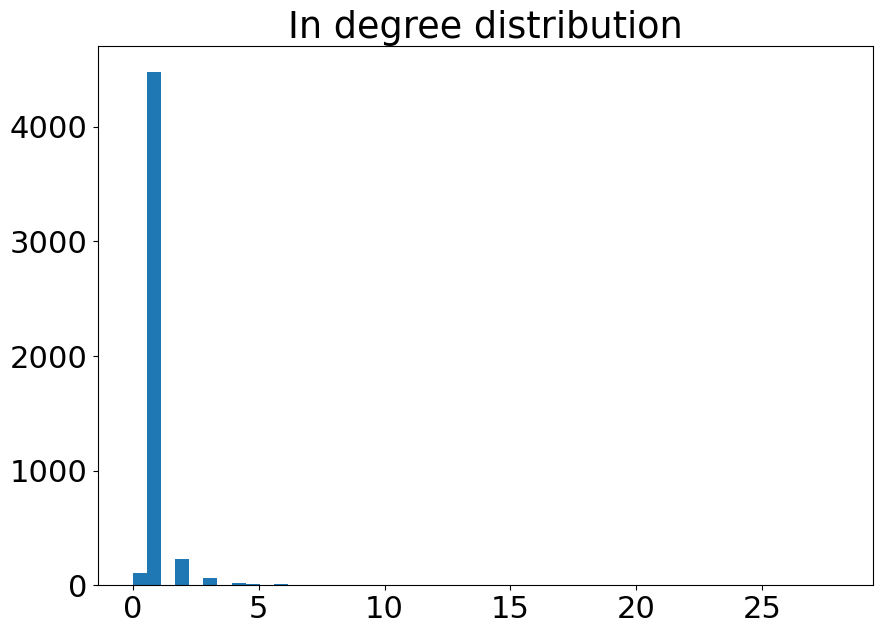

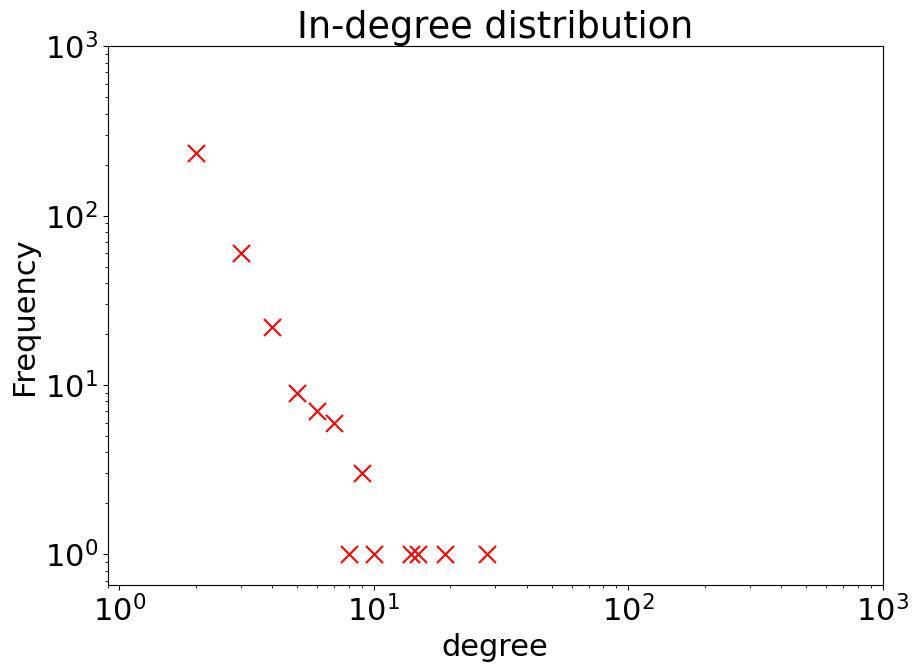

Calculating best minimal value for power law fit
exponential nan, exponential 1.0
power_law -1.0208825924962321, lognormal 0.3073100673932446
exponential -4.124175351773731, power_lab 3.720653694060533e-05
alpha = 1.4575099720263844
xmin = 1.0


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


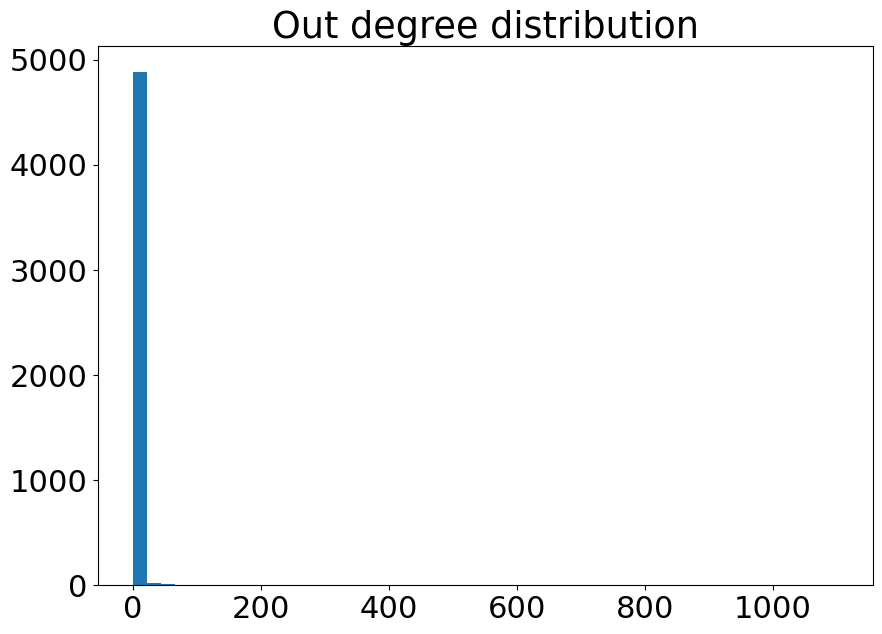

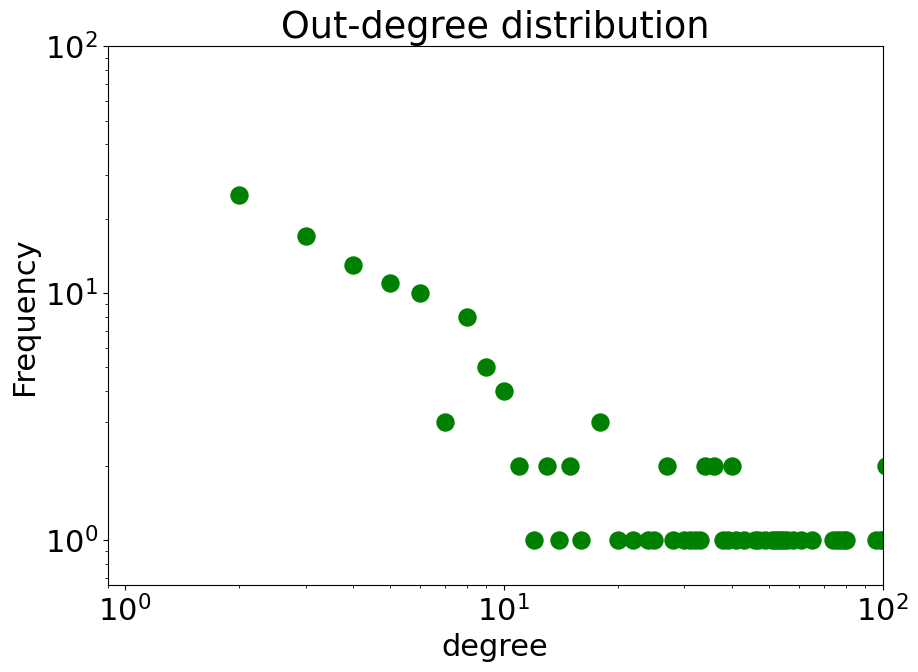

In [40]:
fig_size= [10,7]
plt.rcParams.update({'font.size': 22, "figure.figsize": fig_size})

#Histogram of in-degrees
plt.hist(dict(in_degrees()).values(), bins=50, density=False)
plt.title('In degree distribution')
plt.show()

#Plot log-log of in-degree distribution
plt.yscale('log') 
plt.xscale('log') 

in_degree_counts = dict(collections.Counter(dict(in_degrees()).values()))

#Create scatter plot with degree on x-axis and counts on y-axis
plt.scatter(in_degree_counts.keys(), in_degree_counts.values(), c='r', marker='x', s=150)
plt.xlim((.9, 1e3)) #set x axis limits
plt.ylim((0, 1e3)) #set y axis limits
plt.xlabel('degree')
plt.ylabel('Frequency')
plt.title('In-degree distribution')
plt.show()

data = np.array(list(in_degree_counts.values()),dtype=np.float32)
fit = powerlaw.Fit(data)

R, p = fit.distribution_compare('exponential','exponential',  normalized_ratio=True)
print("exponential {}, exponential {}".format(R, p))
R, p = fit.distribution_compare('power_law','lognormal',  normalized_ratio=True)
print("power_law {}, lognormal {}".format(R, p))
R, p = fit.distribution_compare('exponential','power_law',  normalized_ratio=True)
print("exponential {}, power_lab {}".format(R, p))

print("alpha = {}".format(fit.power_law.alpha))
print("xmin = {}".format(fit.power_law.xmin))

#Histogram of out-degrees
plt.hist(dict(out_degrees()).values(), bins=50, density=False)
plt.title('Out degree distribution')
plt.show()

#Plot log-log of in-degree distribution
plt.yscale('log') 
plt.xscale('log') 

out_degree_counts = dict(collections.Counter(dict(out_degrees()).values())) 

#Create scatter plot with degree on x-axis and counts on y-axis 
plt.scatter(out_degree_counts.keys(), out_degree_counts.values(), c='g', marker='o', s=150)
plt.xlim((.9, 1e2)) #set x axis limits
plt.ylim((0, 1e2)) #set y axis limits
plt.xlabel('degree')
plt.ylabel('Frequency')
plt.title('Out-degree distribution')
plt.show()

##### Path Lengths
<br> path length - max number of transactions from one account to the other 
<br> Network diameter is the longest shortest path between any two nodes in the network.

In [41]:
if not 'avg_path_length' in globals(): 
    max_path_length = 0
    total = 0.0
    for n in G: #iterate over all nodes
        path_length=nx.single_source_shortest_path_length(G, n) 
        total += sum(path_length.values()) #total of all shortest paths from n
    
        if max(path_length.values()) > max_path_length: #keep track of longest shortest path 
            max_path_length = max(path_length.values())         
    avg_path_length = total / (N*(N - 1)) #calculate average.
    
print("Average path length %f" % (avg_path_length)) 
print("Network Diameter or max path length %d" % (max_path_length)) 

Average path length 0.016482
Network Diameter or max path length 9


##### Centrality
**Which account has the highest centrality?**
<br> Betweenness centrality - which account lies on most txn routes
<br> Closeness centrality - which account has the shortest number of transfers to all other account 
<br> Degree centrality - the (general) number of accounts it is connected to
<br> Eigenvector centrality - which account is connected to other important networks
<br> Pagerank - ranks the nodes in the graph based on the structure of the incoming links

**betweenness centrality**

Betweenness mean: 0.000002
1: ('randy villamar', 0.002181405357727194)
2: ('christian angelo delos santos', 0.0012083210349467244)
3: ('mark nester mendoza', 0.0006850085863426671)
4: ('aeron paul alfaro', 0.0005731045223936093)
5: ('estela ocampo', 0.00047181228187367387)
6: ('ian vincent dedase', 0.00044122945222126804)
7: ('roselle calizon', 0.00037672560348683164)
8: ('jon eugene placido', 0.00026316961970041707)
9: ('gina nunez', 0.0002556801009164875)
10: ('shelly sharmaine rb kaamino', 0.00024135253434135829)


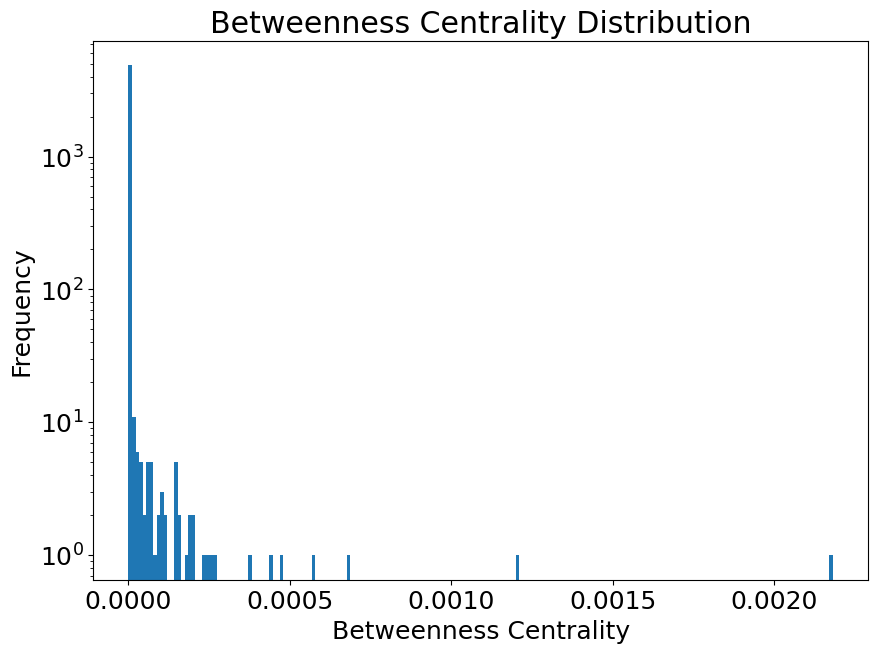

In [42]:
if not 'bet_cen' in globals(): #only calculate this if its not been calculated before 
    bet_cen = nx.betweenness_centrality(G)

#Histogram of betweenness
print("Betweenness mean: %f" % (np.array(list(bet_cen.values())).mean()))

#get a list of acct sorted by betweenness
acct_sorted_by_betweenness = sorted(bet_cen.items(), key=operator.itemgetter(1), reverse=True)

for x in range(10): #print top 10 acct by betweenness
    print(str(x+1)+ ": " + str(acct_sorted_by_betweenness[x]))

#plt.bar(center, hist)
plt.rcParams.update({'font.size': 18})

plt.hist(bet_cen.values(), bins=200, density=False) 
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Betweenness Centrality Distribution')
plt.show()


**closeness centrality**

Closeness mean: 0.001715
1: ('alphared management system inc', 0.012803702578541373)
2: ('john', 0.007333014162831589)
3: ('kenneth', 0.007020577505356226)
4: ('omni four ace link inc', 0.0068173579585752014)
5: ('james', 0.0067349946915790234)
6: ('william', 0.006581701290803257)
7: ('joseph', 0.0063305034872130845)
8: ('richard', 0.006284950943373811)
9: ('allan', 0.006261764791057311)
10: ('christian', 0.006119553031023884)


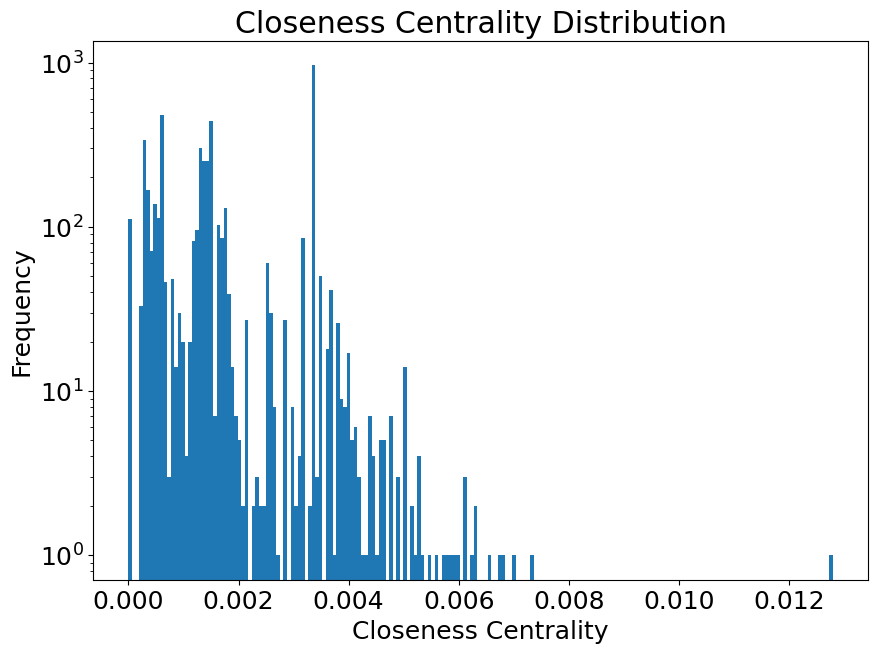

In [43]:
if not 'clo_cen' in globals(): 
    clo_cen = nx.closeness_centrality(G)

#Histogram of closeness
print("Closeness mean: %f" % (np.array(list(clo_cen.values())).mean()))

#get a list of acct sorted by closeness
acct_sorted_by_closeness = sorted(clo_cen.items(), key=operator.itemgetter(1), reverse=True)

for x in range(10): #print top 10 acct by closeness
    print(str(x+1)+ ": " + str(acct_sorted_by_closeness[x]))

#plt.bar(center, hist)
plt.rcParams.update({'font.size': 18})

plt.hist(clo_cen.values(), bins=200, density=False) 
plt.xlabel('Closeness Centrality')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Closeness Centrality Distribution')
plt.show()


**degree centrality**

Degree mean: 0.000449
1: ('randy villamar', 0.22440705453071155)
2: ('bob marley', 0.06892357591729172)
3: ('ian vincent dedase', 0.05817960673018447)
4: ('gerardo cerda jr', 0.0356780863571863)
5: ('estela ocampo', 0.0346645043584026)
6: ('jellie ann santos', 0.0336509223596189)
7: ('mylene baldon', 0.033245489560105417)
8: ('clint paderon', 0.02594769916886276)
9: ('gina nunez', 0.022501520372998175)
10: ('francis cruz', 0.021487938374214473)


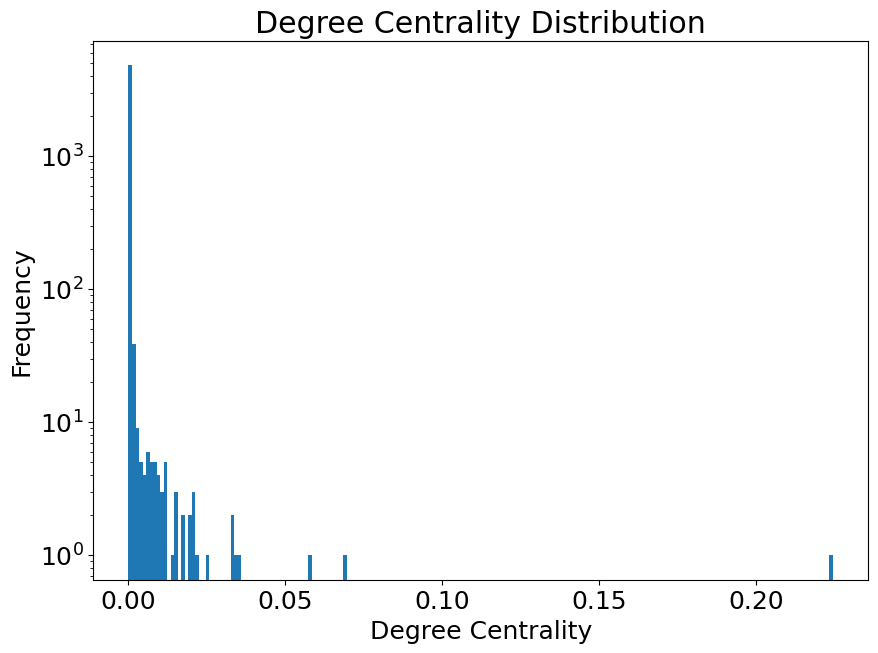

In [44]:
if not 'deg_cen' in globals(): 
    deg_cen = nx.degree_centrality(G)
    
#Histogram of degrees
print("Degree mean: %f" % (np.array(list(deg_cen.values())).mean()))

#get a list of acct sorted by degree
acct_sorted_by_degree = sorted(deg_cen.items(), key=operator.itemgetter(1), reverse=True)

for x in range(10): #print top 10 acct by degree
    print(str(x+1)+ ": " + str(acct_sorted_by_degree[x]))

#plt.bar(center, hist)
plt.rcParams.update({'font.size': 18})

plt.hist(deg_cen.values(), bins=200, density=False) 
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Degree Centrality Distribution')
plt.show()


**eigenvector centrality**

Eigenvector mean: 0.004326
1: ('rogelio villangca', 0.19133115751978977)
2: ('gina nunez', 0.17321810993645897)
3: ('francis cruz', 0.17210712906531797)
4: ('mylene baldon', 0.1640836796371361)
5: ('erdinel cruz', 0.15215034759457857)
6: ('marvin dula', 0.09745470056526606)
7: ('floyd jordan lopez', 0.09201575920790477)
8: ('eric aquino', 0.08657376327179196)
9: ('anthonny d', 0.08657376327179196)
10: ('sunny morante', 0.08657376327179196)


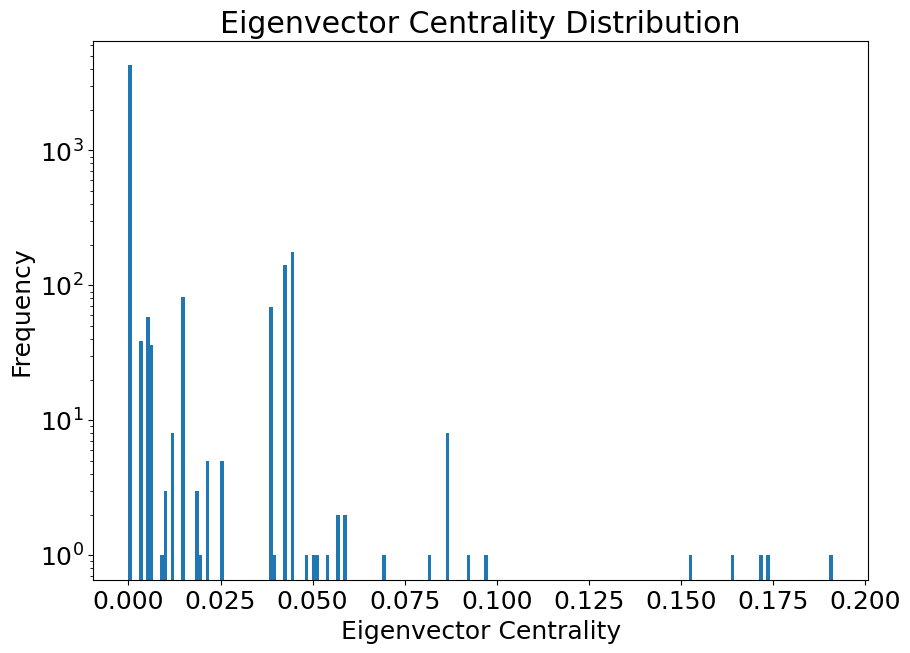

In [45]:
if not 'eig_cen' in globals(): 
    eig_cen = nx.eigenvector_centrality(G, max_iter=200)

#Histogram of eigenvector_centrality
print("Eigenvector mean: %f" % (np.array(list(eig_cen.values())).mean()))

#get a list of acct sorted by betweenness
acct_sorted_by_eigenvector = sorted(eig_cen.items(), key=operator.itemgetter(1), reverse=True)

for x in range(10): #print top 10 acct by eigenvector
    print(str(x+1)+ ": " + str(acct_sorted_by_eigenvector[x]))

#plt.bar(center, hist)
plt.rcParams.update({'font.size': 18})

plt.hist(eig_cen.values(), bins=200, density=False) 
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Eigenvector Centrality Distribution')
plt.show()


**pagerank**

Pagerank mean: 0.000203
1: ('christian angelo delos santos', 0.0027009874793970513)
2: ('mark nester mendoza', 0.0017205771318939838)
3: ('aeron paul alfaro', 0.0014349821101300763)
4: ('alphared management system inc', 0.0012554193935781761)
5: ('darlence mae boston', 0.0012165330415687613)
6: ('erdinel cruz', 0.0009472214719589722)
7: ('annadel vitan', 0.0008993993199516595)
8: ('simmonette alonzo', 0.0008866051628357934)
9: ('ronald de leon', 0.0008518175071945766)
10: ('john ildefonso villanueva', 0.0008350809975971557)


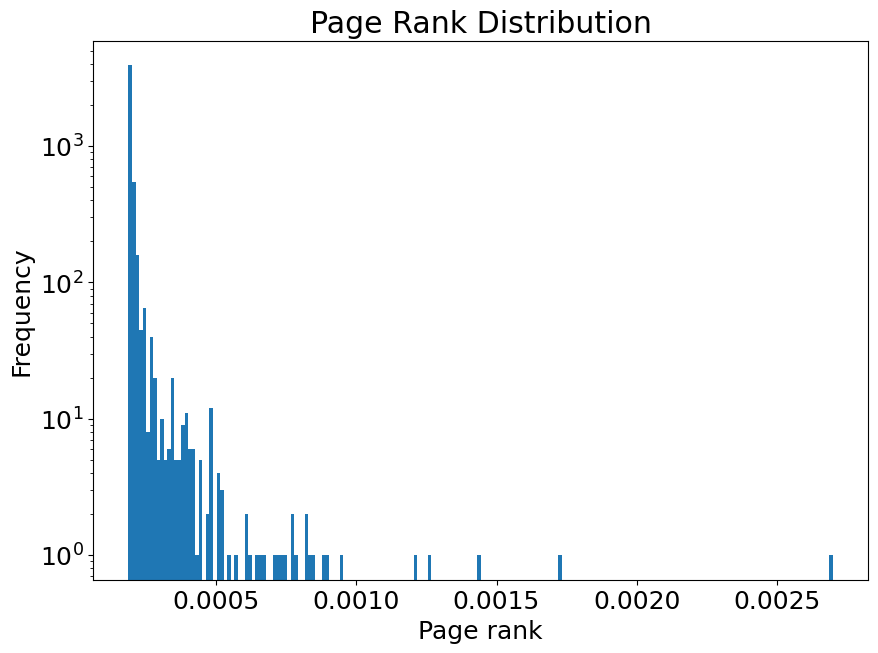

In [46]:
if not 'pagerank_cen' in globals(): 
    pagerank_cen = nx.pagerank(G, max_iter=200)

#Histogram of pagerank
print("Pagerank mean: %f" % (np.array(list(pagerank_cen.values())).mean()))

#get a list of acct sorted by betweenness
acct_sorted_by_pagerank = sorted(pagerank_cen.items(), key=operator.itemgetter(1), reverse=True)

for x in range(10): #print top 10 acct by pagerank
    print(str(x+1)+ ": " + str(acct_sorted_by_pagerank[x]))

#plt.bar(center, hist)
plt.rcParams.update({'font.size': 18})

plt.hist(pagerank_cen.values(), bins=200, density=False) 
plt.xlabel('Page rank')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Page Rank Distribution')
plt.show()

#### Separate fraud/not fraud network for comparison

#####  Only fraud 

**Build graph**
<br> **define nodes/edges**

In [48]:
lvl3_fraud = lvl3_final[lvl3_final['response']==1]
lvl3_fraud

,tran_date,source_name,target_name,TargetBank,txn_amount,response
0,2021-03-04,john ildefonso villanueva,jennifer iracta,UBP,40000.0,1
41,2021-04-05,personal savings,mbc number,UBP,19650.0,1
89,2021-03-29,gemmel pecana,alexa mae espiritu,UBP,9980.0,1
137,2021-04-05,gemmel pecana,alexa mae espiritu,UBP,15000.0,1
215,2021-03-03,jennifer iracta,john ildefonso villanueva,UBP,15000.0,1
...,...,...,...,...,...,...
97725,2021-05-01,claryza fello,ralph lauren d lanzona,NonUBP,2000.0,1
97726,2021-05-01,claryza fello,joanna joy petelo,NonUBP,50000.0,1
97727,2021-05-01,claryza fello,marilyn ralcones,NonUBP,1000.0,1
97728,2021-05-01,claryza fello,gretchen v penales,NonUBP,15000.0,1


In [49]:
# define edges 
df_edges = lvl3_fraud[['source_name','target_name','txn_amount']]

# define nodes 
df_source = lvl3_fraud[['source_name','response']]
df_target = lvl3_fraud[['target_name','response']]

# node colours 
node_colours = {1 : 'red', 0 : 'green'}
df_source['node_colour'] = lvl3_fraud['response'].map(node_colours)
df_target['node_colour'] = lvl3_fraud['response'].map(node_colours)

# create network 
G_fraud = nx.from_pandas_edgelist(df_edges, source = 'source_name', target = 'target_name', edge_attr = 'txn_amount', create_using=nx.DiGraph())


##### Network statistics

In [50]:
N_fraud = G_fraud.order() #G.order(), gives number of nodes 
L_fraud = G_fraud.size() #G.size(), gives number of edges

avg_deg_fraud = float(L_fraud) / N_fraud #calculate average degree

print("Nodes: ", N_fraud)
print("Edges: ", L_fraud)
print("Average degree: ", avg_deg_fraud)

Nodes:  4905
Edges:  5427
Average degree:  1.1064220183486237


**in-degree/out-degree**

In [51]:
# In-degree and Out-degree
in_degrees_fraud = G_fraud.in_degree()  # dictionary node:degree
out_degrees_fraud = G_fraud.out_degree()

# Example
print("Transactions in personal savings: %d" % in_degrees_fraud['personal savings']) #txn in personal savings
print("Transactions out personal savings: %d" % out_degrees_fraud['personal savings']) #txn out of personal savings


Transactions in personal savings: 0
Transactions out personal savings: 10


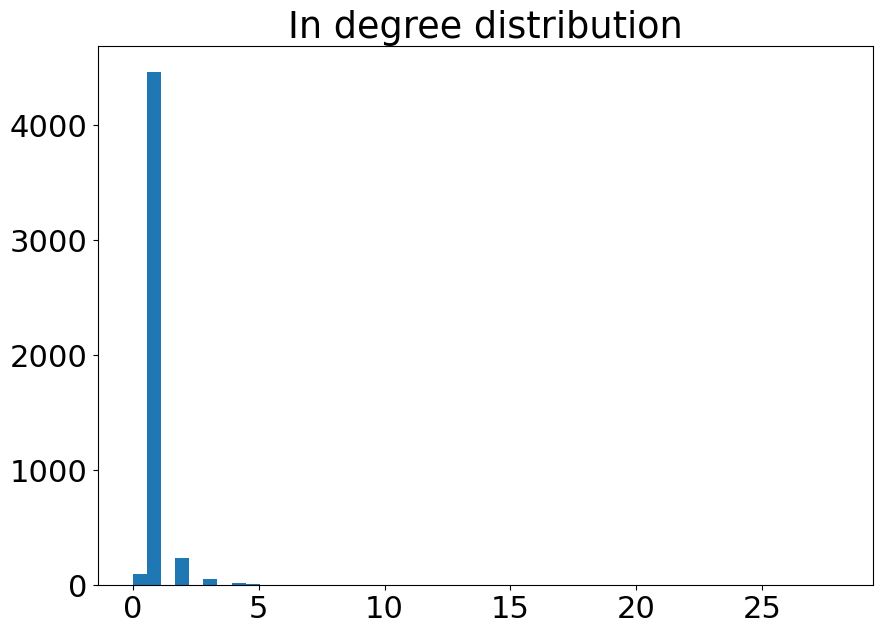

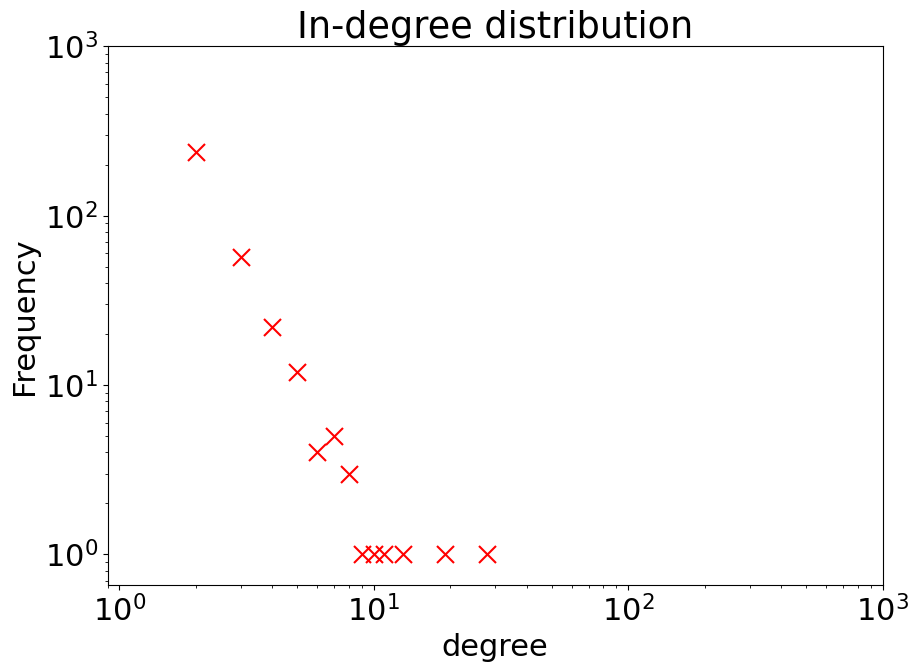

Calculating best minimal value for power law fit
exponential nan, exponential 1.0
power_law -0.8316399625464247, lognormal 0.4056121981091002
exponential -4.2069455863969605, power_lab 2.5884543474250112e-05
alpha = 1.4662801607891756
xmin = 1.0


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


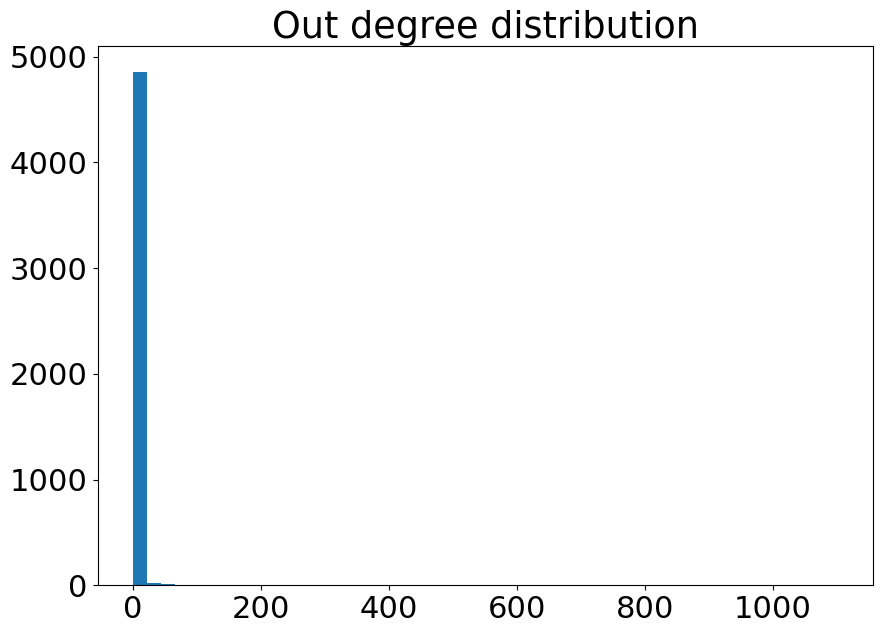

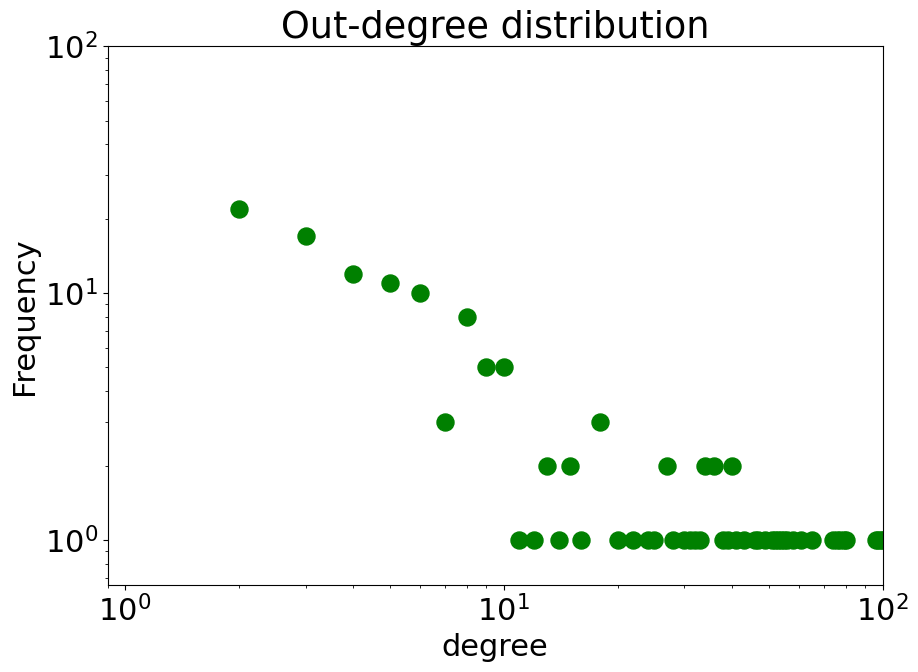

In [52]:
fig_size= [10,7]
plt.rcParams.update({'font.size': 22, "figure.figsize": fig_size})

#Histogram of in-degrees
plt.hist(dict(in_degrees_fraud()).values(), bins=50, density=False)
plt.title('In degree distribution')
plt.show()

#Plot log-log of in-degree distribution
plt.yscale('log') 
plt.xscale('log') 

in_degree_fraud_counts = dict(collections.Counter(dict(in_degrees_fraud()).values()))

#Create scatter plot with degree on x-axis and counts on y-axis
plt.scatter(in_degree_fraud_counts.keys(), in_degree_fraud_counts.values(), c='r', marker='x', s=150)
plt.xlim((.9, 1e3)) #set x axis limits
plt.ylim((0, 1e3)) #set y axis limits
plt.xlabel('degree')
plt.ylabel('Frequency')
plt.title('In-degree distribution')
plt.show()

data_fraud = np.array(list(in_degree_fraud_counts.values()),dtype=np.float32)
fit_fraud = powerlaw.Fit(data_fraud)

R, p = fit_fraud.distribution_compare('exponential','exponential',  normalized_ratio=True)
print("exponential {}, exponential {}".format(R, p))
R, p = fit_fraud.distribution_compare('power_law','lognormal',  normalized_ratio=True)
print("power_law {}, lognormal {}".format(R, p))
R, p = fit_fraud.distribution_compare('exponential','power_law',  normalized_ratio=True)
print("exponential {}, power_lab {}".format(R, p))

print("alpha = {}".format(fit_fraud.power_law.alpha))
print("xmin = {}".format(fit_fraud.power_law.xmin))

#Histogram of out-degrees
plt.hist(dict(out_degrees_fraud()).values(), bins=50, density=False)
plt.title('Out degree distribution')
plt.show()

#Plot log-log of in-degree distribution
plt.yscale('log') 
plt.xscale('log') 

out_degree_fraud_counts = dict(collections.Counter(dict(out_degrees_fraud()).values())) 

#Create scatter plot with degree on x-axis and counts on y-axis 
plt.scatter(out_degree_fraud_counts.keys(), out_degree_fraud_counts.values(), c='g', marker='o', s=150)
plt.xlim((.9, 1e2)) #set x axis limits
plt.ylim((0, 1e2)) #set y axis limits
plt.xlabel('degree')
plt.ylabel('Frequency')
plt.title('Out-degree distribution')
plt.show()

#####  Only not-fraud 

In [53]:
lvl3_nonfraud = lvl3_final[lvl3_final['response']==0]
lvl3_nonfraud

,tran_date,source_name,target_name,TargetBank,txn_amount,response
487,2021-03-01,nino sanguin,john ildefonso villanueva,UBP,2000.0,0
559,2021-03-04,mariejane bentor,john ildefonso villanueva,UBP,1500.0,0
36000,2021-04-27,bryan panimdim,jeff jester jacobe,UBP,4980.0,0
36680,2021-03-18,ricky basco,rolando ango,UBP,5000.0,0
36758,2021-04-06,ma lea camille f. cabanting,jellie ann santos,UBP,110000.0,0
54408,2021-03-16,jameboy pamor,aeron paul alfaro,UBP,22900.0,0
59846,2021-03-16,seth guilbert almendral,aeron paul alfaro,UBP,1200.0,0
60560,2021-03-25,jovert p millano,aeron paul alfaro,UBP,1000.0,0
61358,2021-04-27,kheberlie flores,mark nester mendoza,UBP,15000.0,0
61506,2021-03-29,monitha germano pagaran,mark nester mendoza,UBP,3900.0,0


In [54]:
lvl3_nonfraud.shape

(37, 6)

In [55]:
# define edges 
df_edges = lvl3_nonfraud[['source_name','target_name','txn_amount']]

# define nodes 
df_source = lvl3_nonfraud[['source_name','response']]
df_target = lvl3_nonfraud[['target_name','response']]

# node colours 
node_colours = {1 : 'red', 0 : 'green'}
df_source['node_colour'] = lvl3_nonfraud['response'].map(node_colours)
df_target['node_colour'] = lvl3_nonfraud['response'].map(node_colours)

# create network 
G_nonfraud = nx.from_pandas_edgelist(df_edges, source = 'source_name', target = 'target_name', edge_attr = 'txn_amount', create_using=nx.DiGraph())


##### Network statistics

In [56]:
N_nonfraud = G_nonfraud.order() #G.order(), gives number of nodes 
L_nonfraud = G_nonfraud.size() #G.size(), gives number of edges

avg_deg_nonfraud = float(L_nonfraud) / N_nonfraud #calculate average degree

print("Nodes: ", N_nonfraud)
print("Edges: ", L_nonfraud)
print("Average degree: ", avg_deg_nonfraud)

Nodes:  53
Edges:  36
Average degree:  0.6792452830188679


**in-degree/out-degree**

In [57]:
# In-degree and Out-degree
in_degrees_nonfraud = G_nonfraud.in_degree()  # dictionary node:degree
out_degrees_nonfraud = G_nonfraud.out_degree()

# Example
print("Transactions in personal savings: %d" % in_degrees_nonfraud['aeron paul alfaro']) #txn in personal savings
print("Transactions out personal savings: %d" % out_degrees_nonfraud['aeron paul alfaro']) #txn out of personal savings


Transactions in personal savings: 3
Transactions out personal savings: 0


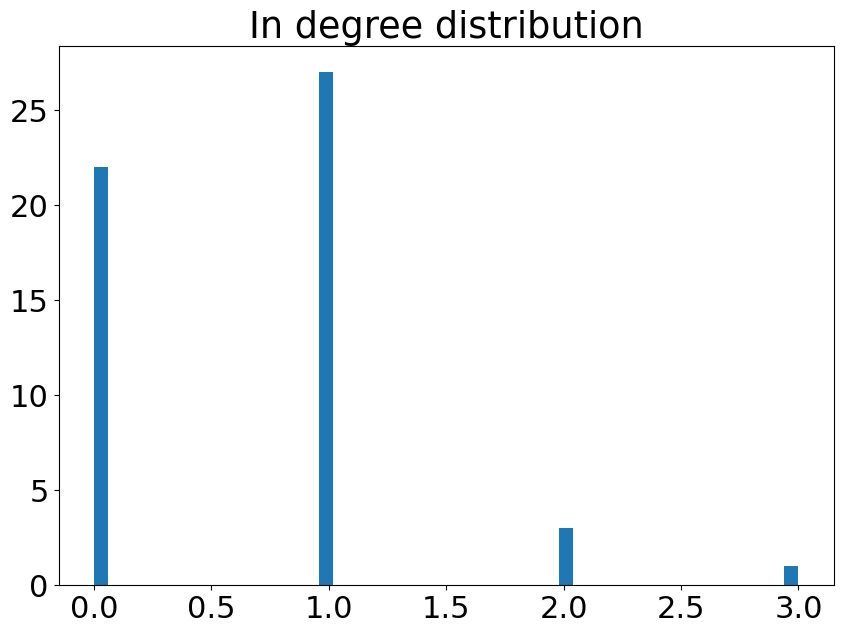

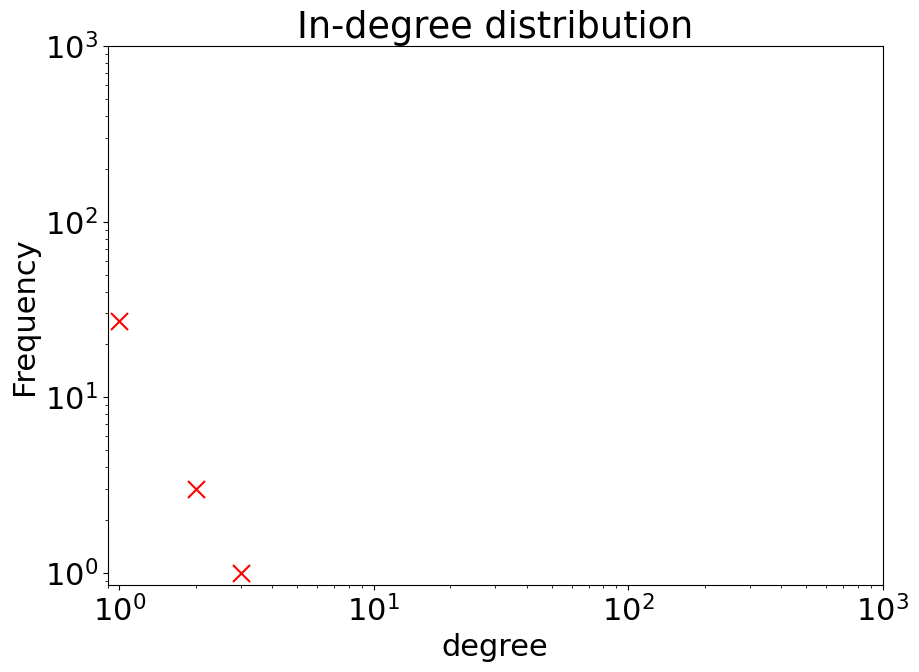

Calculating best minimal value for power law fit
exponential nan, exponential 1.0
power_law -0.3281520473368787, lognormal 0.7427967026964429
exponential -0.012119334456230844, power_lab 0.990330406859595
alpha = 1.5343670408645744
xmin = 1.0


Assuming nested distributions


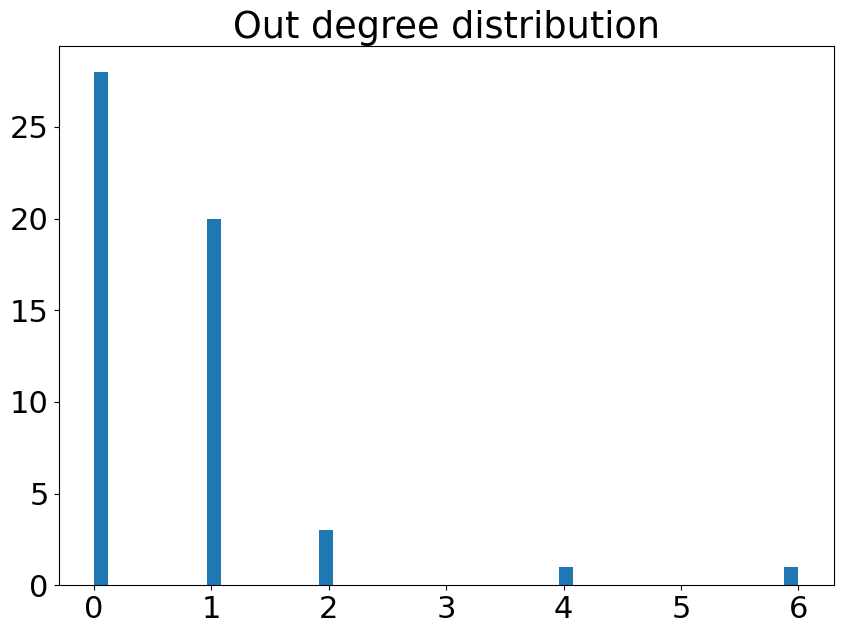

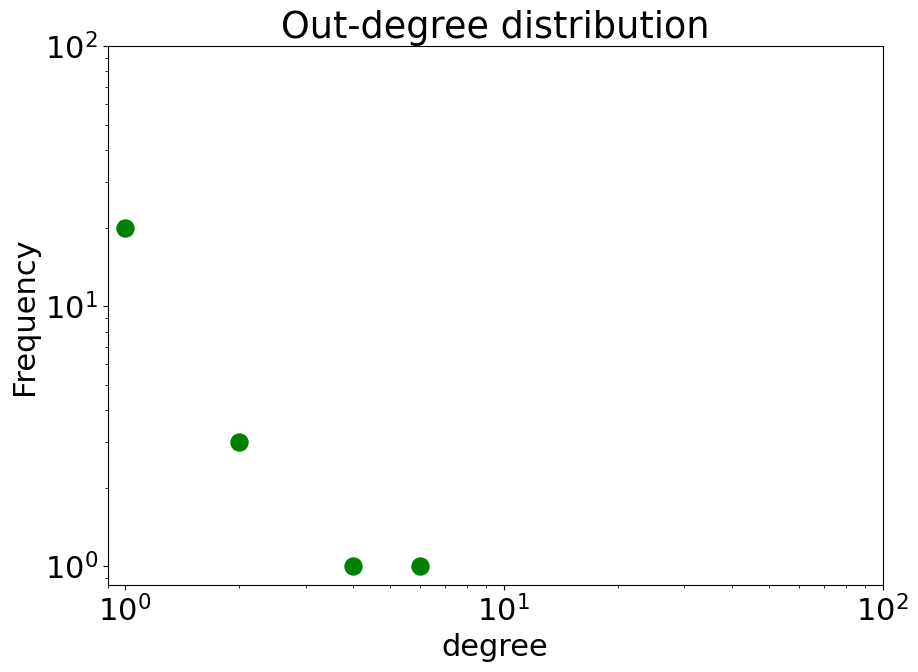

In [58]:
fig_size= [10,7]
plt.rcParams.update({'font.size': 22, "figure.figsize": fig_size})

#Histogram of in-degrees
plt.hist(dict(in_degrees_nonfraud()).values(), bins=50, density=False)
plt.title('In degree distribution')
plt.show()

#Plot log-log of in-degree distribution
plt.yscale('log') 
plt.xscale('log') 

in_degree_nonfraud_counts = dict(collections.Counter(dict(in_degrees_nonfraud()).values()))

#Create scatter plot with degree on x-axis and counts on y-axis
plt.scatter(in_degree_nonfraud_counts.keys(), in_degree_nonfraud_counts.values(), c='r', marker='x', s=150)
plt.xlim((.9, 1e3)) #set x axis limits
plt.ylim((0, 1e3)) #set y axis limits
plt.xlabel('degree')
plt.ylabel('Frequency')
plt.title('In-degree distribution')
plt.show()

data_nonfraud = np.array(list(in_degree_nonfraud_counts.values()),dtype=np.float32)
fit_nonfraud = powerlaw.Fit(data_nonfraud)

R, p = fit_nonfraud.distribution_compare('exponential','exponential',  normalized_ratio=True)
print("exponential {}, exponential {}".format(R, p))
R, p = fit_nonfraud.distribution_compare('power_law','lognormal',  normalized_ratio=True)
print("power_law {}, lognormal {}".format(R, p))
R, p = fit_nonfraud.distribution_compare('exponential','power_law',  normalized_ratio=True)
print("exponential {}, power_lab {}".format(R, p))

print("alpha = {}".format(fit_nonfraud.power_law.alpha))
print("xmin = {}".format(fit_nonfraud.power_law.xmin))

#Histogram of out-degrees
plt.hist(dict(out_degrees_nonfraud()).values(), bins=50, density=False)
plt.title('Out degree distribution')
plt.show()

#Plot log-log of in-degree distribution
plt.yscale('log') 
plt.xscale('log') 

out_degree_nonfraud_counts = dict(collections.Counter(dict(out_degrees_nonfraud()).values())) 

#Create scatter plot with degree on x-axis and counts on y-axis 
plt.scatter(out_degree_nonfraud_counts.keys(), out_degree_nonfraud_counts.values(), c='g', marker='o', s=150)
plt.xlim((.9, 1e2)) #set x axis limits
plt.ylim((0, 1e2)) #set y axis limits
plt.xlabel('degree')
plt.ylabel('Frequency')
plt.title('Out-degree distribution')
plt.show()

#### fraud/not fraud comparison

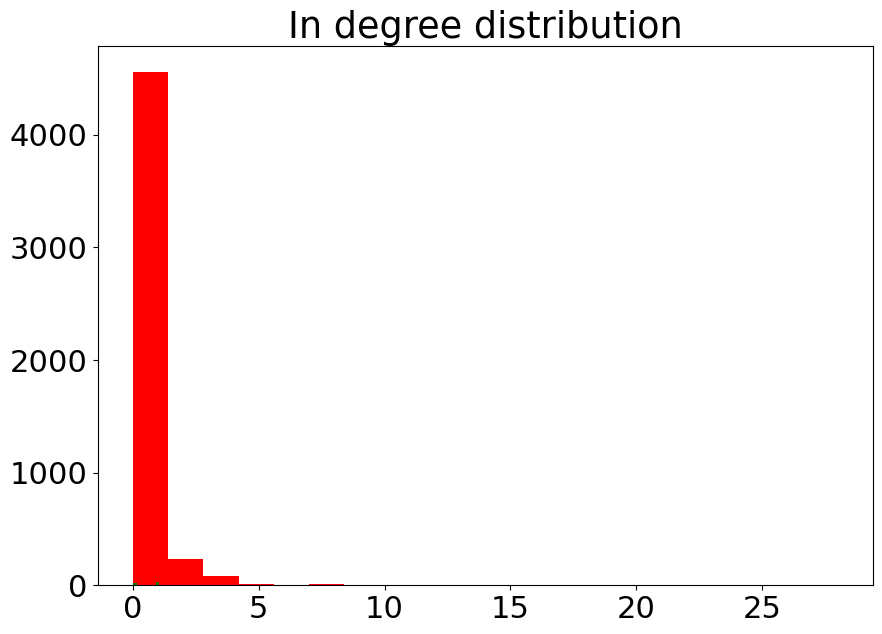

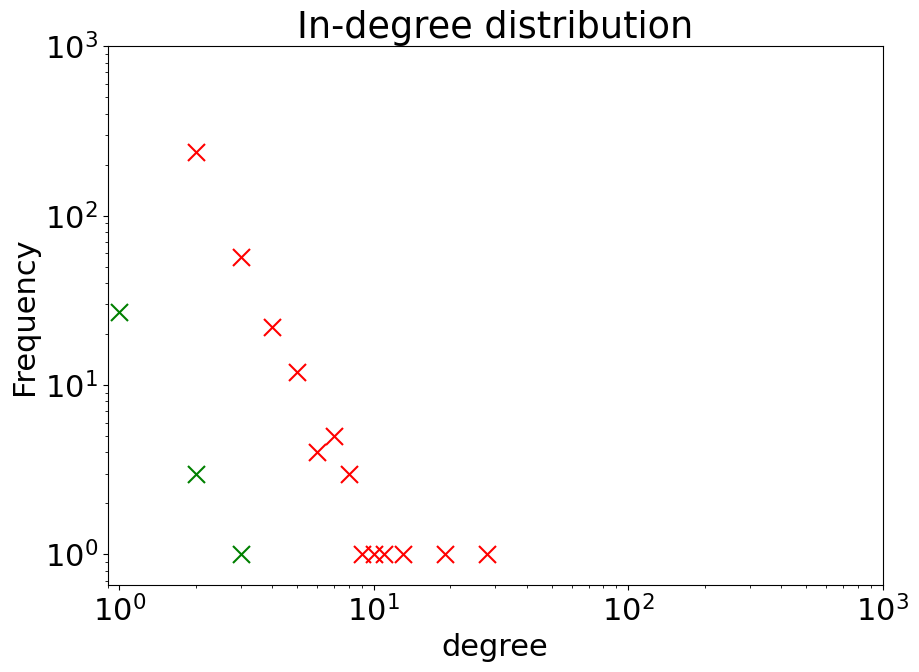

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


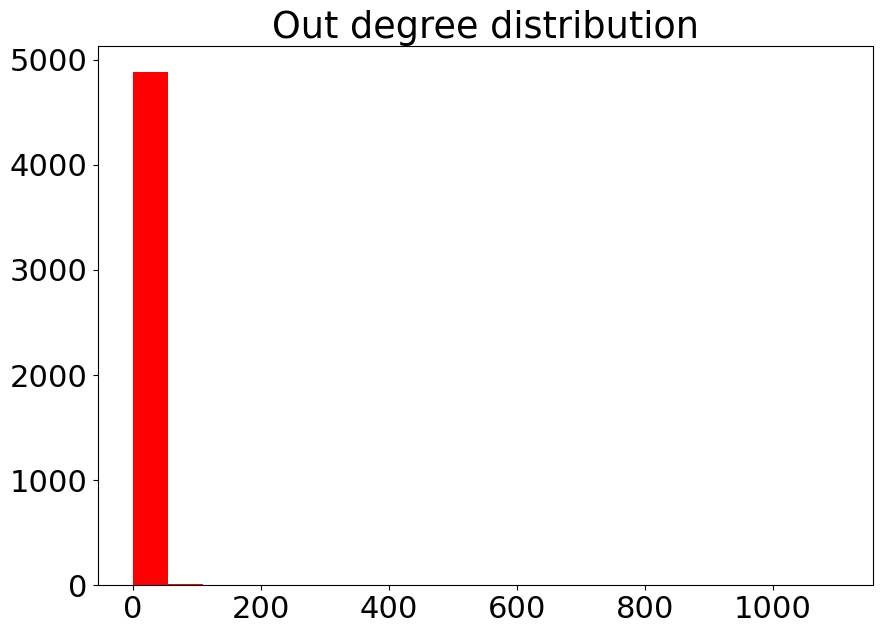

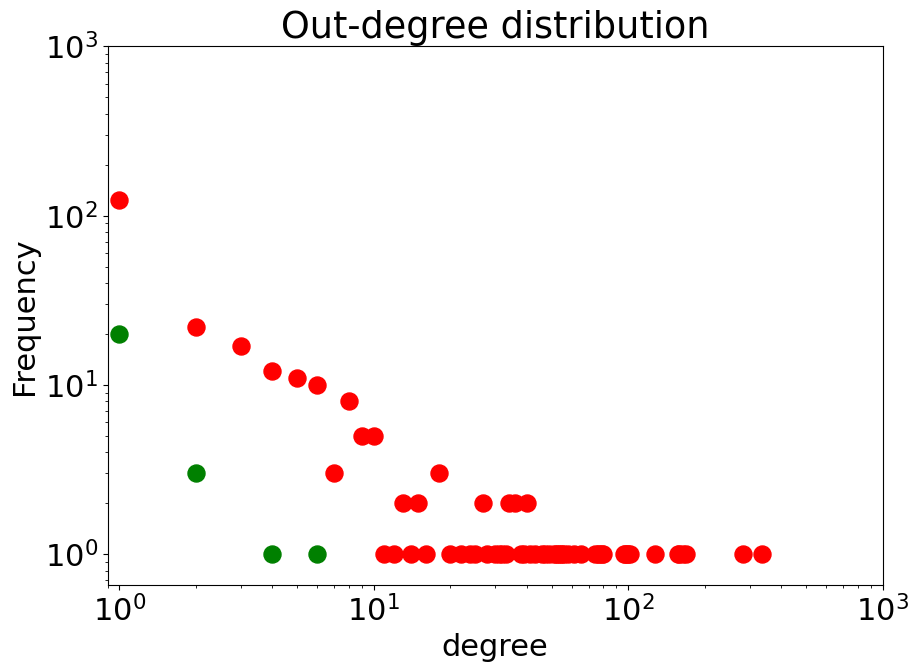

In [59]:
fig_size= [10,7]
plt.rcParams.update({'font.size': 22, "figure.figsize": fig_size})

#Histogram of in-degrees
plt.hist(dict(in_degrees_fraud()).values(), bins=20, density=False, color='red')
plt.hist(dict(in_degrees_nonfraud()).values(), bins=20, density=False,color='green')
plt.title('In degree distribution')
plt.show()

#Plot log-log of in-degree distribution
plt.yscale('log') 
plt.xscale('log') 

in_degree_fraud_counts = dict(collections.Counter(dict(in_degrees_fraud()).values()))
in_degree_nonfraud_counts = dict(collections.Counter(dict(in_degrees_nonfraud()).values()))

#Create scatter plot with degree on x-axis and counts on y-axis
plt.scatter(in_degree_fraud_counts.keys(), in_degree_fraud_counts.values(), c='r', marker='x', s=150)
plt.scatter(in_degree_nonfraud_counts.keys(), in_degree_nonfraud_counts.values(), c='g', marker='x', s=150)
plt.xlim((.9, 1e3)) #set x axis limits
plt.ylim((0, 1e3)) #set y axis limits
plt.xlabel('degree')
plt.ylabel('Frequency')
plt.title('In-degree distribution')
plt.show()

data_nonfraud = np.array(list(in_degree_nonfraud_counts.values()),dtype=np.float32)
fit_nonfraud = powerlaw.Fit(data_nonfraud)
data_fraud = np.array(list(in_degree_fraud_counts.values()),dtype=np.float32)
fit_fraud = powerlaw.Fit(data_fraud)

#Histogram of out-degrees
plt.hist(dict(out_degrees_fraud()).values(), bins=20, density=False, color='red')
plt.hist(dict(out_degrees_nonfraud()).values(), bins=20, density=False, color='green')
plt.title('Out degree distribution')
plt.show()

#Plot log-log of in-degree distribution
plt.yscale('log') 
plt.xscale('log') 

out_degree_fraud_counts = dict(collections.Counter(dict(out_degrees_fraud()).values())) 
out_degree_nonfraud_counts = dict(collections.Counter(dict(out_degrees_nonfraud()).values())) 

#Create scatter plot with degree on x-axis and counts on y-axis 
plt.scatter(out_degree_fraud_counts.keys(), out_degree_fraud_counts.values(), c='r', marker='o', s=150)
plt.scatter(out_degree_nonfraud_counts.keys(), out_degree_nonfraud_counts.values(), c='g', marker='o', s=150)
plt.xlim((.9, 1e3)) #set x axis limits
plt.ylim((0, 1e3)) #set y axis limits
plt.xlabel('degree')
plt.ylabel('Frequency')
plt.title('Out-degree distribution')
plt.show()

##### Correlation of centrality measures to fraud

In [60]:
# create network 
# directed graph
G = nx.from_pandas_edgelist(df_edges, source = 'source_name', target = 'target_name', edge_attr = 'txn_amount', create_using=nx.DiGraph())


In [61]:
nodes_info_dict = {
    'betweenness_centrality': nx.betweenness_centrality,
    'closeness_centrality': nx.closeness_centrality,
    'eigenvector_centrality': nx.eigenvector_centrality_numpy, # otherwise, cannot converge without _numpy
    'pagerank': nx.pagerank 
}

columns_with_node_infos = ['degree'] + list(nodes_info_dict.keys())

nodes_info = pd.DataFrame.from_dict(dict(nx.degree(G)), orient='index').rename(columns = {0 : 'degree'}).reset_index()


In [62]:
G.order() # number of nodes, should match below

53

In [63]:
nodes_info # should match G.order()

,index,degree
0,nino sanguin,1
1,john ildefonso villanueva,2
2,mariejane bentor,1
3,bryan panimdim,1
4,jeff jester jacobe,1
...,...,...
48,mark henson a,1
49,mark henson a,1
50,richmon jaysam atienza,1
51,janine marie de torres,1


In [64]:
# computing graph features for each node
for info, fun in nodes_info_dict.items():
    temp = pd.DataFrame.from_dict(fun(G), orient='index').rename(columns = {0 : info}).reset_index()
    nodes_info = nodes_info.merge(temp, on='index')

nodes_info = nodes_info.rename(columns = {'index': 'name'})

In [65]:
nodes_info

,name,degree,betweenness_centrality,closeness_centrality,eigenvector_centrality,pagerank
0,nino sanguin,1,0.0,0.000000,2.424796e-17,0.013080
1,john ildefonso villanueva,2,0.0,0.038462,-4.593094e-17,0.035318
2,mariejane bentor,1,0.0,0.000000,-6.334052e-17,0.013080
3,bryan panimdim,1,0.0,0.000000,-8.292760e-17,0.013080
4,jeff jester jacobe,1,0.0,0.019231,-6.725084e-17,0.024199
...,...,...,...,...,...,...
48,mark henson a,1,0.0,0.019231,1.480660e-17,0.018640
49,mark henson a,1,0.0,0.019231,4.459807e-17,0.018640
50,richmon jaysam atienza,1,0.0,0.025641,4.472136e-01,0.019357
51,janine marie de torres,1,0.0,0.025641,4.472136e-01,0.019357


In [67]:
# adding graph features to df
# merge on source_name
lvl3_cen = lvl3_final[['source_name','target_name','tran_date','TargetBank', 'txn_amount','response']].merge(nodes_info, left_on = 'source_name',  
                           right_on='name', how='left').drop('name', axis=1)
lvl3_cen.rename(columns = {k:'source_'+k for k in columns_with_node_infos}, inplace = True)

# merge on target_name
lvl3_cen = lvl3_cen.merge(nodes_info, left_on = 'target_name', 
                           right_on='name', how='left').drop('name', axis=1)
lvl3_cen.rename(columns = {k:'target_'+k for k in columns_with_node_infos}, inplace = True)
                
lvl3_cen

,source_name,target_name,tran_date,TargetBank,txn_amount,response,source_degree,source_betweenness_centrality,source_closeness_centrality,source_eigenvector_centrality,source_pagerank,target_degree,target_betweenness_centrality,target_closeness_centrality,target_eigenvector_centrality,target_pagerank
0,john ildefonso villanueva,jennifer iracta,2021-03-04,UBP,40000.0,1,2.0,0.0,0.038462,-4.593094e-17,0.035318,NaN,NaN,NaN,NaN,NaN
1,personal savings,mbc number,2021-04-05,UBP,19650.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,gemmel pecana,alexa mae espiritu,2021-03-29,UBP,9980.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,gemmel pecana,alexa mae espiritu,2021-04-05,UBP,15000.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,jennifer iracta,john ildefonso villanueva,2021-03-03,UBP,15000.0,1,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.038462,-4.593094e-17,0.035318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6718,claryza fello,ralph lauren d lanzona,2021-05-01,NonUBP,2000.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6719,claryza fello,joanna joy petelo,2021-05-01,NonUBP,50000.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6720,claryza fello,marilyn ralcones,2021-05-01,NonUBP,1000.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6721,claryza fello,gretchen v penales,2021-05-01,NonUBP,15000.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
lvl3_cen.isnull().sum()

source_name                         0
target_name                         0
tran_date                           0
TargetBank                          0
txn_amount                          0
response                            0
source_degree                    5587
source_betweenness_centrality    5587
source_closeness_centrality      5587
source_eigenvector_centrality    5587
source_pagerank                  5587
target_degree                    6406
target_betweenness_centrality    6406
target_closeness_centrality      6406
target_eigenvector_centrality    6406
target_pagerank                  6406
dtype: int64

In [69]:
lvl3_cen.corr()

,txn_amount,response,source_degree,source_betweenness_centrality,source_closeness_centrality,source_eigenvector_centrality,source_pagerank,target_degree,target_betweenness_centrality,target_closeness_centrality,target_eigenvector_centrality,target_pagerank
txn_amount,1.000000,-0.013034,-0.019274,-0.083194,0.228622,0.074386,0.253995,-0.044499,-0.004703,-0.032496,0.132598,-0.142503
response,-0.013034,1.000000,-0.076928,-0.064789,0.270430,-0.362370,0.197479,-0.034055,-0.008383,-0.064184,-0.348246,-0.050228
source_degree,-0.019274,-0.076928,1.000000,0.967392,0.140802,0.092007,0.217372,-0.193051,-0.147491,-0.061987,0.253123,-0.313151
source_betweenness_centrality,-0.083194,-0.064789,0.967392,1.000000,-0.075232,0.063128,0.001208,-0.185559,-0.115124,-0.113805,0.173858,-0.371880
source_closeness_centrality,0.228622,0.270430,0.140802,-0.075232,1.000000,-0.014355,0.939486,-0.140159,-0.216401,0.154232,0.037344,0.149006
source_eigenvector_centrality,0.074386,-0.362370,0.092007,0.063128,-0.014355,1.000000,0.031131,0.038944,0.027517,-0.040801,1.000000,-0.072218
source_pagerank,0.253995,0.197479,0.217372,0.001208,0.939486,0.031131,1.000000,-0.159115,-0.245853,0.227261,0.147291,0.160924
target_degree,-0.044499,-0.034055,-0.193051,-0.185559,-0.140159,0.038944,-0.159115,1.000000,0.873716,0.329355,0.051314,0.441964
target_betweenness_centrality,-0.004703,-0.008383,-0.147491,-0.115124,-0.216401,0.027517,-0.245853,0.873716,1.000000,-0.086202,0.043637,0.011730
target_closeness_centrality,-0.032496,-0.064184,-0.061987,-0.113805,0.154232,-0.040801,0.227261,0.329355,-0.086202,1.000000,-0.017147,0.835856


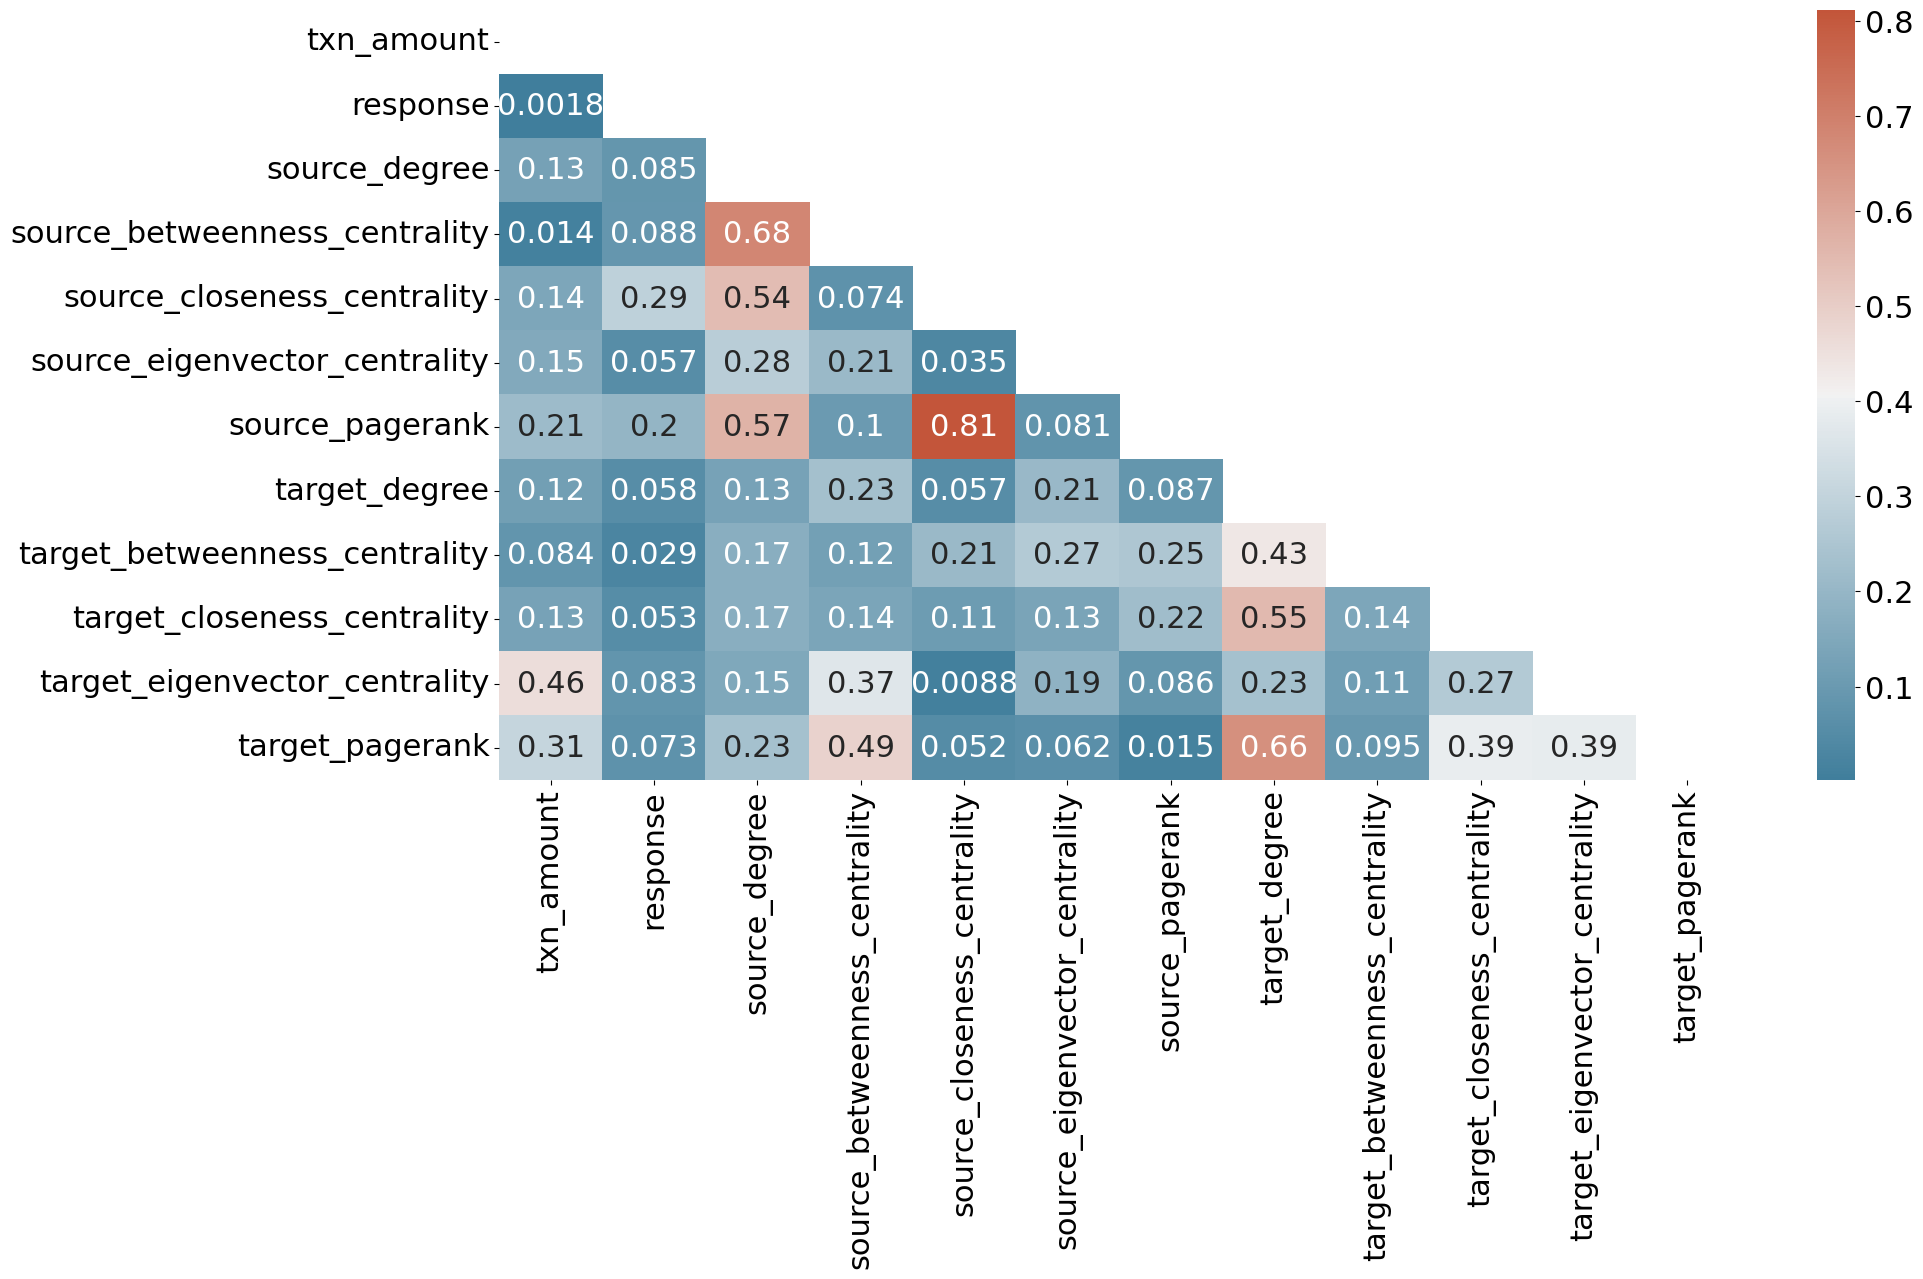

In [70]:
# plotting correlation 
plt.figure(figsize=(20,10))
mask = np.triu(np.ones_like(np.abs(lvl3_cen.corr()), dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(np.abs(lvl3_cen.corr(method='spearman')),
            cmap=cmap,
            mask=mask,
            annot=True,
            fmt='.2g'
           );

In [71]:
# test for monotonic correlation with fraud
cen_corr = lvl3_cen.corr(method='spearman').abs()
cen_corr.loc[cen_corr['response']>=0.05,['response']].sort_values(by=['response'],ascending=False)

,response
response,1.000000
source_closeness_centrality,0.289985
source_pagerank,0.196745
source_betweenness_centrality,0.088400
source_degree,0.085300
target_eigenvector_centrality,0.082906
target_pagerank,0.072660
target_degree,0.058140
source_eigenvector_centrality,0.057246
target_closeness_centrality,0.053145


#### Network visualisation

**networkx**

In [72]:
# define edges 
df_edges = lvl3_final[['source_name','target_name','txn_amount']]

# define nodes 
df_source = lvl3_final[['source_name','response']]
df_target = lvl3_final[['target_name','response']]

# create network 
G = nx.from_pandas_edgelist(df_edges, source = 'source_name', target = 'target_name', edge_attr = 'txn_amount', create_using=nx.DiGraph())


In [73]:
# plt.figure(figsize=(15,15)) 

# # create the layout
# pos = nx.spring_layout(G)

# # draw the nodes and the edges (all)
# nx.draw_networkx_nodes(G,pos,node_color='b',alpha=0.2,node_size=16)
# nx.draw_networkx_edges(G,pos,alpha=0.5);

# plt.savefig('level3_lag7_basic.png',format='png') 
# plt.show()

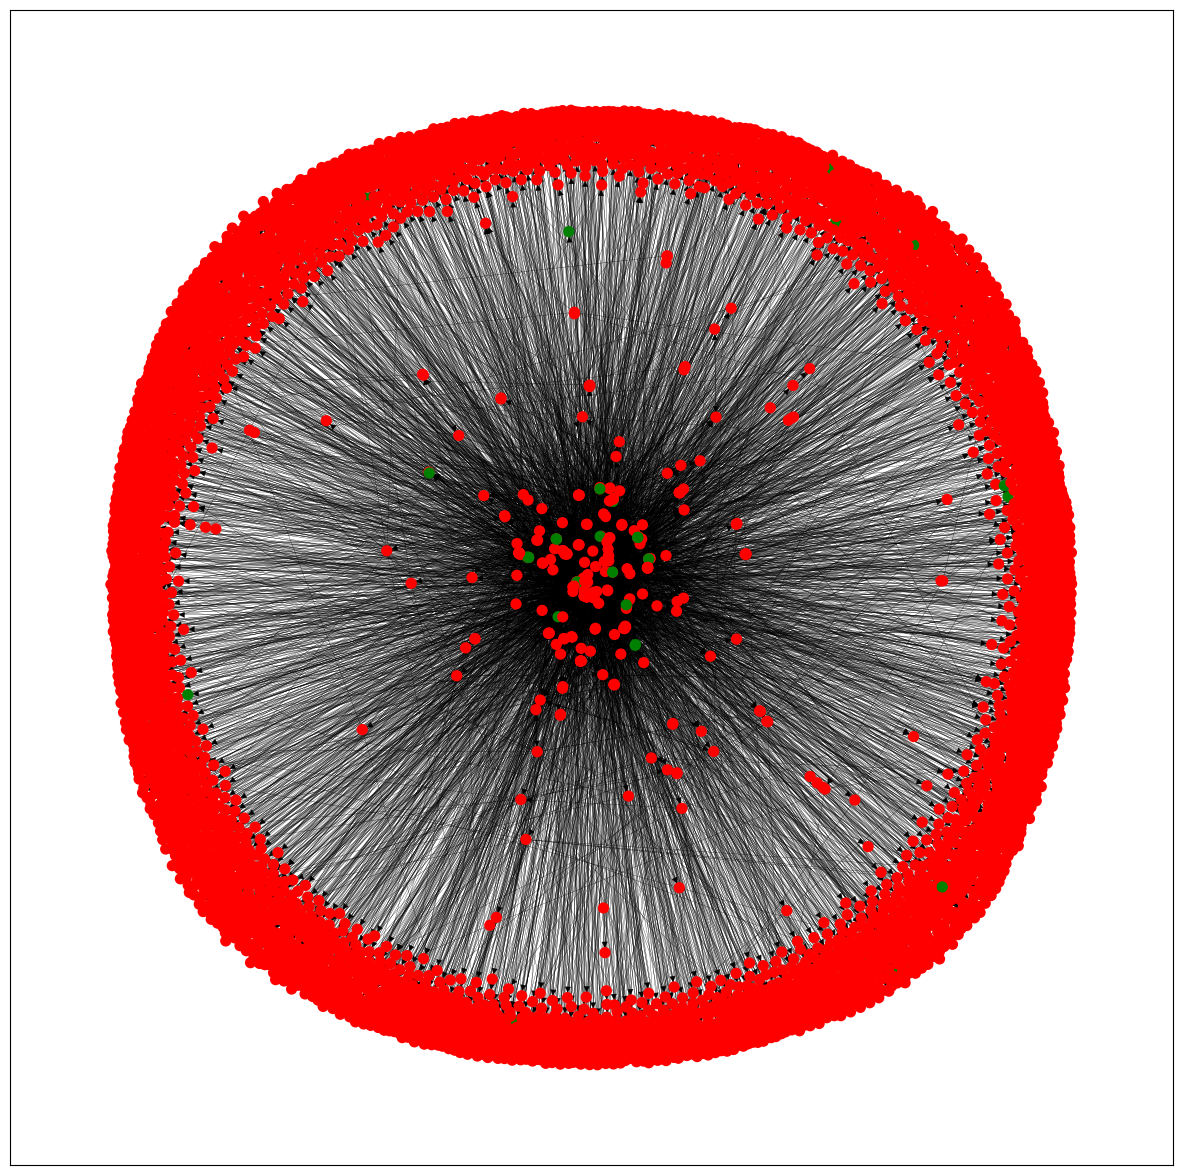

In [74]:
plt.figure(figsize=(15,15)) 
nx.draw_networkx(G, 
    pos = nx.spring_layout(G, weight = 'txn_amount'), # based on optimal distance between nodes 
    node_size = 50, 
    node_color = [fraud_colour[n] for n in G.nodes()],
#     width = [G.edges[e]['txn_amount'] for e in G.edges],
    width = 0.2,
    with_labels = False)
plt.plot();

plt.savefig('level3_lag7_colornode.png',format='png') 
plt.show()

**bokeh**

In [76]:
# # # Use the spring layout to position the nodes
# pos = nx.spring_layout(G, weight = 'txn_amount')

# plot = figure(title='level 3', tools='', toolbar_location=None)

# graph = from_networkx(G, pos, scale=10, center=(0,0))
# plot.renderers.append(graph)

# output_file("level_3_lag7.html")
# show(plot)

In [78]:
# define edge colours
not_fraud_colour, fraud_colour = 'green', 'red'
edge_attrs = {}

for start_node, end_node, _ in G.edges(data=True):
    edge_colour = not_fraud_colour if df_source[df_source['source_name']==start_node]['response'].iloc[0] == 0 else fraud_colour
    edge_attrs[(start_node, end_node)] = edge_colour

nx.set_edge_attributes(G, name='edge_colour', values=edge_attrs)

# set nodes
degrees = dict(nx.degree(G))
nx.set_node_attributes(G, name='degree', values=degrees)

source_response = {k:v['response'] for k, v in source_attr.items()}
target_response = {k:v['response'] for k, v in target_attr.items()}
fraud_response = {**source_response, **target_response}
nx.set_node_attributes(G, name='fraud_response', values=fraud_response)

node_size = dict([(node, degree) for node, degree in nx.degree(G)])
nx.set_node_attributes(G, name='node_size', values=node_size)
# node_colours = {1 : 'red', 0 : 'green'}
# 1 - red/green 
mapper = linear_cmap('fraud_response', palette=Spectral8, low=1, high=1, low_color='green', high_color='red')

# Show with Bokeh
plot = Plot(width=600, height=600,
            x_range=Range1d(-20.1, 20.1), y_range=Range1d(-20.1, 20.1))
plot.title.text = 'level 3'

node_hover_tool = HoverTool(tooltips=[('name', '@index'), ('degree', '@degree')])
plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool(), TapTool(),WheelZoomTool())

graph_renderer = from_networkx(G, nx.spring_layout, scale=2, center=(0, 0))

# graph_renderer.node_renderer.glyph = Circle(size=5, fill_color=Spectral4[0])
graph_renderer.node_renderer.glyph = Circle(size='node_size', fill_color=mapper)

graph_renderer.edge_renderer.glyph = MultiLine(line_color='edge_colour', line_alpha=0.8, line_width=1)
plot.renderers.append(graph_renderer)

output_file('sy_level_3.html')
show(plot)

#### Modularity 
Community detection is a measure of network structure. It was designed to measure the strength of division of a network into modules. Networks with high modularity have dense connections between the nodes within modules but sparse connections between nodes in different modules.


Identify partitions within the network and then colour nodes based on which partition they lie in. 

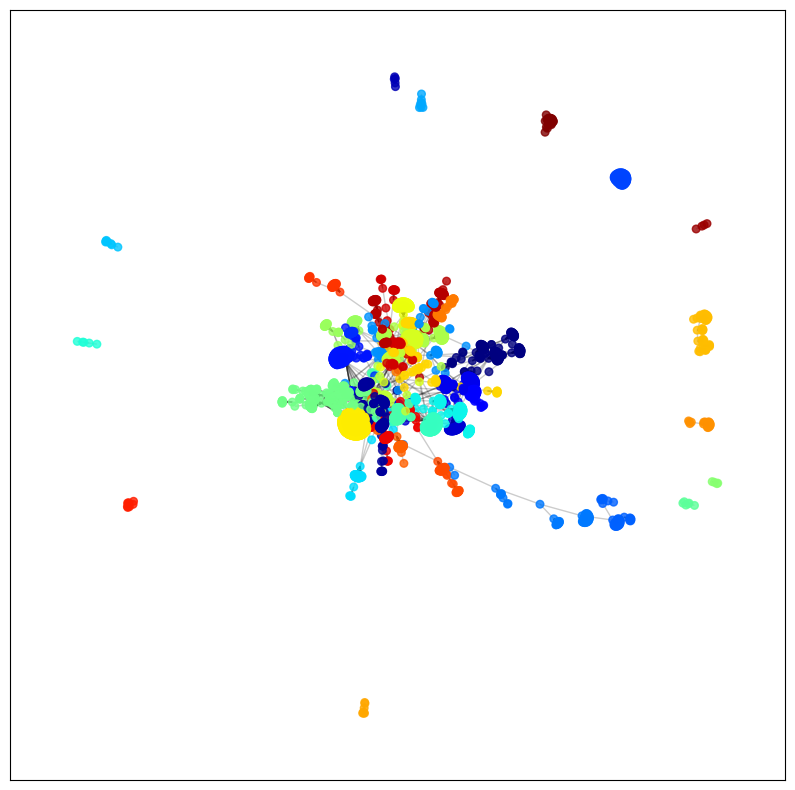

In [79]:
# Unfortunately, the network first has to be undirected.
G_ud = G.to_undirected() 
N = G_ud.order() # number of nodes

nx.transitivity(G_ud)

# find modularity
part = community.best_partition(G_ud)
mod = community.modularity(part, G_ud)

# plot, color nodes using community structure
values = [part.get(node) for node in G_ud.nodes()]
#k indicates separation strength, bigger=> further apart nodes
pos = nx.spring_layout(G_ud, iterations=100, k=100.0/N) 

plt.figure(figsize=(10,10)) 
nx.draw_networkx_nodes(G_ud,
                       pos,
                       cmap=plt.get_cmap('jet'),
                       node_color=values, 
                       node_size=30, 
                       label=None,
                       alpha=0.8)

nx.draw_networkx_edges(G_ud,
                       pos,
                       alpha=0.2)

plt.savefig('network_cluster_lvl3.png')
plt.show()


**export output to file**

In [80]:
nx.write_graphml(G,'fraud_network_lvl3.graphml') 
nx.write_gml(G,'fraud_network_lvl3.gml') 
nx.write_gexf(G, 'fraud_network_lvl3.gexf')


##### Modularity-Based Community Detection: The Louvain Method
The modularity quantifies how good a "community" or partition is, and is given by ___ where n is the number of communities,
L is the number of links within the community, k is the total degree of nodes belonging to the community, and L is the total number of links in the network. 

In [81]:
G_ud = G.to_undirected() 
partition = community.community_louvain.best_partition(G_ud)

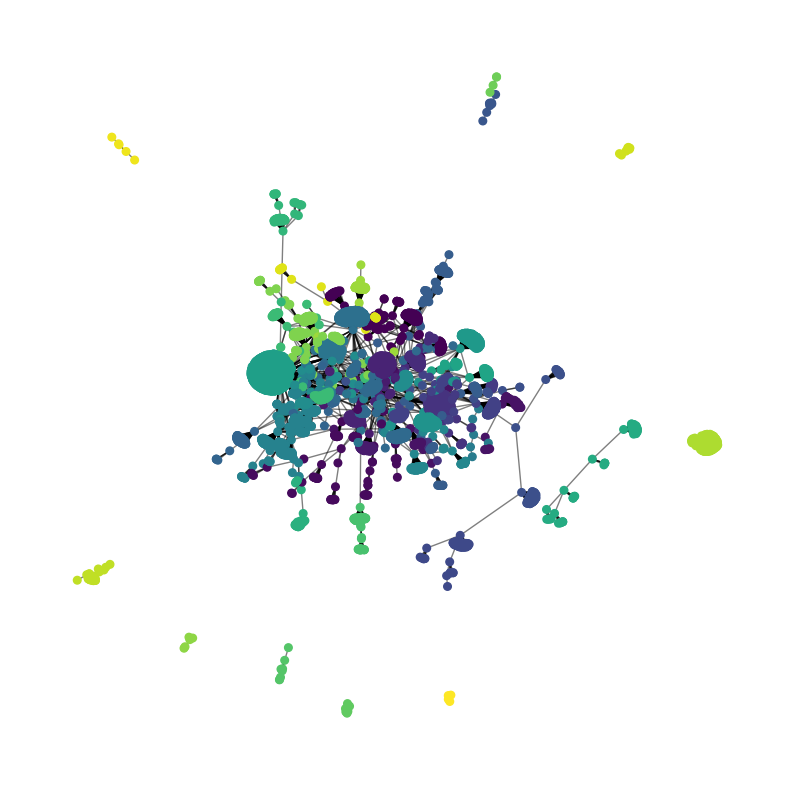

In [82]:
plt.figure(figsize=(10,10))
plt.axis('off')

pos = nx.spring_layout(G_ud)
nx.draw_networkx_nodes(G_ud, pos, node_size=30, node_color=list(partition.values()))
nx.draw_networkx_edges(G_ud, pos, alpha=0.5)
# nx.draw_networkx_labels(G_ud, pos)

plt.savefig('mod_louvain_lvl3.png')
plt.show()


In [83]:
np.unique(list(partition.values())).max()

41

##### cliques
Cliques are complete subgraphs; that is, subgraphs are where the nodes are all directly connected to each other. A subgraph of a graph G having vertex set V and edge set E is a graph H having edge set contained in V and edge set contained in E. 
Note that any two connected nodes in an undirected network are considered to form a clique.

In [84]:
# # Unfortunately, the network first has to be undirected.
# G_ud = G.to_undirected() 

# for _ in list(nx.find_cliques(G_ud)):
#     print(_)

In [85]:
# nx.graph_number_of_cliques(G_ud)

**no point to find cliques. they are just start to end nodes, max size 3?**